# Import dependencies

In [4]:
!pip install keras

    100% |████████████████████████████████| 337kB 3.5MB/s eta 0:00:01
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import sys
sys.path.append('input/Mask_RCNN')

In [18]:
import os
import sys
import random
import math
import re
import time

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel

from config import Config
import utils
import model as modellib
import visualize
from model import log

In [7]:
tf.set_random_seed(127)

Let's download the mask_rcnn trained on COCO dataset to initialize the model.

In [8]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

We will now define the monitor that will help keep track on the training process.
With this you will be able to see your charts in the `charts` tab

In [9]:
class LossHistory(Callback):  
    def on_train_begin(self, logs={}):
        self.batch_id = 0
        self.epoch_id = 0

    def on_batch_end(self, batch, logs={}):
        self.batch_id += 1
        ctx.channel_send('loss', x=self.batch_id, y=float(logs.get('loss')))
        ctx.channel_send('rpn_class_loss', x=self.batch_id, y=float(logs.get('rpn_class_loss')))
        ctx.channel_send('rpn_bbox_loss', x=self.batch_id, y=float(logs.get('rpn_bbox_loss')))
        ctx.channel_send('mrcnn_class_loss', x=self.batch_id, y=float(logs.get('mrcnn_class_loss')))
        ctx.channel_send('mrcnn_bbox_loss', x=self.batch_id, y=float(logs.get('mrcnn_bbox_loss')))
        ctx.channel_send('mrcnn_mask_loss', x=self.batch_id, y=float(logs.get('mrcnn_mask_loss')))
    
    def on_epoch_end(self, batch, logs={}):
        self.epoch_id += 1
        ctx.channel_send('val_loss', x=self.epoch_id, y=float(logs.get('val_loss')))
        ctx.channel_send('val_rpn_class_loss', x=self.epoch_id, y=float(logs.get('val_rpn_class_loss')))
        ctx.channel_send('val_rpn_bbox_loss', x=self.epoch_id, y=float(logs.get('val_rpn_bbox_loss')))
        ctx.channel_send('val_mrcnn_class_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_class_loss')))
        ctx.channel_send('val_mrcnn_bbox_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_bbox_loss')))
        ctx.channel_send('val_mrcnn_mask_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_mask_loss')))

Now we will load the metadata and divide them in train and valid splits

In [10]:
def train_valid_split(meta, validation_size, valid_category_ids=None):
    meta_train = meta[meta['is_train'] == 1]
    meta_train_split, meta_valid_split = split_on_column(meta_train,
                                                         column='vgg_features_clusters',
                                                         test_size=validation_size,
                                                         random_state=1234,
                                                         valid_category_ids=valid_category_ids
                                                         )
    return meta_train_split, meta_valid_split


def split_on_column(meta, column, test_size, random_state=1, valid_category_ids=None):
    if valid_category_ids is None:
        categories = meta[column].unique()
        np.random.seed(random_state)
        valid_category_ids = np.random.choice(categories,
                                              int(test_size * len(categories)))
    valid = meta[meta[column].isin(valid_category_ids)].sample(frac=1, random_state=random_state)
    train = meta[~(meta[column].isin(valid_category_ids))].sample(frac=1, random_state=random_state)
    return train, valid

meta = pd.read_csv('/public/dsb_2018_data/stage1_metadata.csv')

meta_ts = meta[meta['is_train']==0]
meta_train, meta_valid = train_valid_split( meta[meta['is_train']==1],0.2,[0])

# Mask-RCNN configuration
We will now define parameters for our mask-rcnn. 
Tweak them to get better results!

In [11]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_NMS_THRESHOLD = 0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 400 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
config = DsbConfig()

In [12]:
class InferenceConfig(DsbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # MEAN_PIXEL = np.array([56.02288505, 54.02376286, 54.26675248])
inference_config = InferenceConfig()

# Dataset definition

We need to define our datasets for the data science bowl competition

In [13]:
class DsbDataset(utils.Dataset):

    def load_dataset(self, ids, train_mode=True):
        self.add_class("dsb", 1, "nuclei")
        if train_mode:
            directory = dsb_dir
        else:
            directory = test_dir
        for i, id in enumerate(ids):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            

    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        if image.shape[2] != 3:
            image = image[:,:,:3]
        image = self.preprocess(image)
        image = image.astype('float32')
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
            msk = msk.astype('float32')/255.
            mask.append(msk)
        mask = np.asarray(mask)
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img):
        gray = skimage.color.rgb2gray(img.astype('uint8'))
        img = skimage.color.gray2rgb(gray)
        img *= 255.
        return img

In [14]:
dsb_dir = '/public/dsb_2018_data/stage1_train'
train_ids = meta_train.ImageId.values
val_ids = meta_valid.ImageId.values
test_dir = '/public/dsb_2018_data/stage1_test'
test_ids = os.listdir(test_dir)

In [15]:
# Training dataset
dataset_train = DsbDataset()
dataset_train.load_dataset(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = DsbDataset()
dataset_val.load_dataset(val_ids)
dataset_val.prepare()

# Test dataset
dataset_test = DsbDataset()
dataset_test.load_dataset(test_ids, train_mode=False)
dataset_test.prepare()

Let's take a look at some images

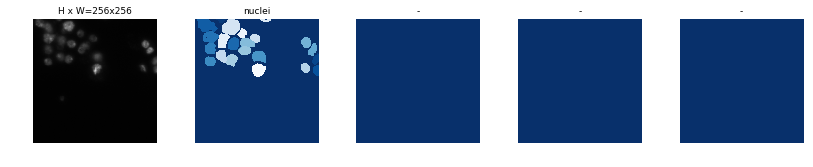

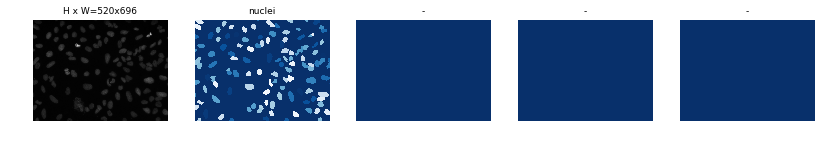

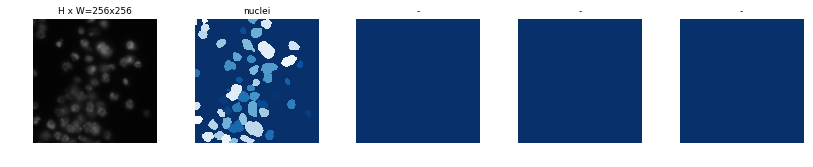

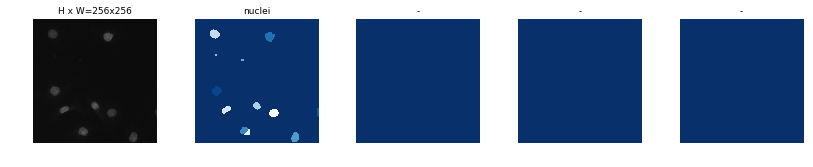

In [19]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Model Training

OK! 

I think we are ready to do some training!
We will instantiate the model and initialize it with COCO weights

In [31]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [32]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

Let's train and investigate the learning curves for all the mask-rcnn losses in the `charts` and `channels`

In [34]:
model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE,
                epochs=10, 
                layers="all")
#                 layers="all", clbcks=[LossHistory()])


Starting at epoch 0. LR=0.01

Checkpoint Path: /neptune/logs/dsb20180414T0200/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchN

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
299/300 [============================>.] - ETA: 2s - loss: 1.3401 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2743

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


300/300 [==============================] - 878s 3s/step - loss: 1.3394 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 0.5172 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.2743 - val_loss: 0.7345 - val_rpn_class_loss: 0.0276 - val_rpn_bbox_loss: 0.3079 - val_mrcnn_class_loss: 0.1508 - val_mrcnn_bbox_loss: 0.1085 - val_mrcnn_mask_loss: 0.1398
Epoch 2/10
300/300 [==============================] - 843s 3s/step - loss: 0.8796 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3015 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.2397 - val_loss: 0.5874 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.2298 - val_mrcnn_class_loss: 0.1035 - val_mrcnn_bbox_loss: 0.0843 - val_mrcnn_mask_loss: 0.1493
Epoch 3/10
300/300 [==============================] - 842s 3s/step - loss: 0.8189 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.2345 - val_loss: 0.5071 - val_rpn_class_loss: 0.0195

# Evaluate
I think we are ready to see how our model does on the validation!

In [20]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /neptune/logs/dsb20180414T0200/mask_rcnn_dsb_0010.h5


In [21]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (512, 512, 3)         min:    9.00000  max:  245.56250  float32
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  float64
gt_class_id              shape: (18,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (18, 4)               min:    0.00000  max:  510.00000  int32
gt_mask                  shape: (512, 512, 18)        min:    0.00000  max:    1.00000  float32


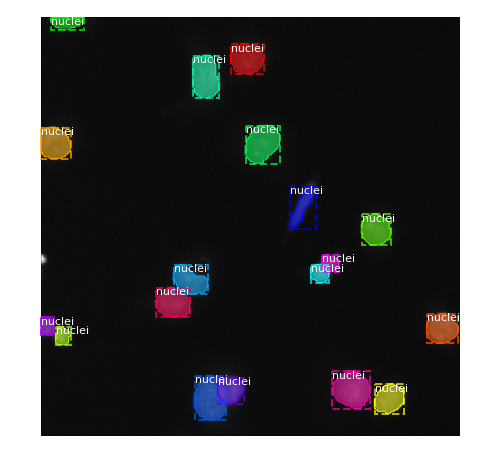

In [22]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  245.56250  float32
molded_images            shape: (1, 512, 512, 3)      min:    9.00000  max:  245.56250  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


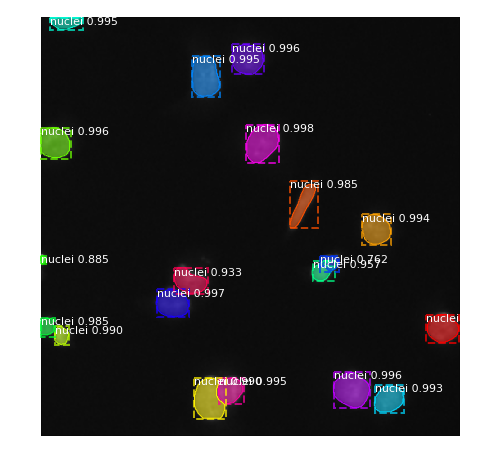

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# TEST EXAMPLE

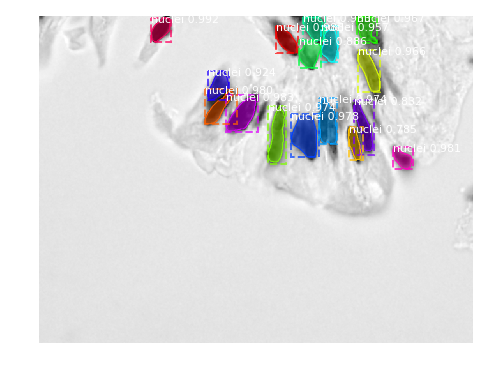

In [50]:
# test_id = 11
# test_id = 28
test_id = 33
test_image1 = dataset_test.load_image(test_id, 0)
pred = model.detect([test_image1], verbose=0)
pred = pred[0]

visualize.display_instances(test_image1, pred['rois'], pred['masks'], pred['class_ids'], 
                        dataset_train.class_names, pred['scores'], ax=get_ax())



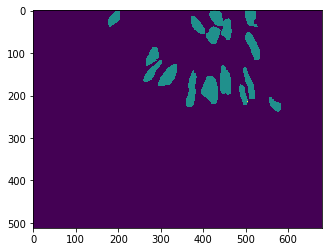

In [51]:
sc = pred['scores']
predm = pred['masks']
predMask = np.sum(predm, axis=2)
plt.imshow(predMask)

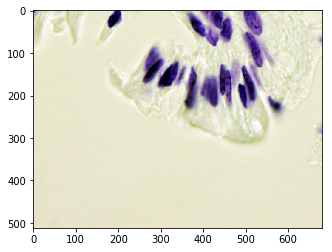

In [52]:
imName = test_ids[test_id]
imFullName = os.path.join(test_dir, imName, 'images', imName + '.png')
# imFile = skimage.io.imread(imFullName)
imFile = imageio.imread(imFullName)
plt.imshow(imFile)

# Create Submission
It is looking good on the validation.
Let's see how will it do on the public LB.

In [39]:
raw_predictions = []
for test_id in dataset_test.image_ids:
    test_image1 = dataset_test.load_image(test_id, 0)
    pred = model.detect([test_image1], verbose=0)
    pred = pred[0]
    sc = pred['scores']
    pred = pred['masks']
    raw_predictions.append((pred, sc))

In [51]:
test_image1 = dataset_test.load_image(1, 0)
pred = model.detect([test_image1], verbose=0)
pred = pred[0]
sc = pred['scores']
pred = pred['masks']

In [55]:
pred.shape

(520, 696, 30)

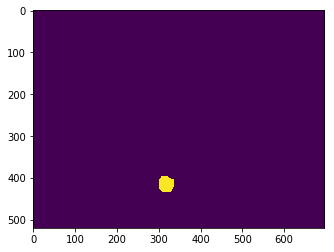

In [57]:
plt.imshow(pred[:,:,1]) # predicted mask for individual cell in 1 image

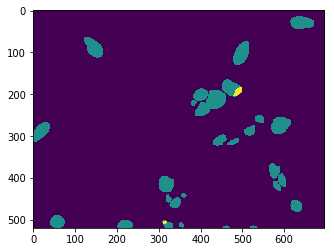

In [58]:
plt.imshow(np.sum(pred, axis=2)) # predicted mask for all cells in 1 image

In [40]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [41]:
def numpy2encoding_no_overlap(predicts, img_name, scores):
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [42]:
new_test_ids = []
rles = []
for id, raw_pred in zip(test_ids, raw_predictions):
    ids, rle = numpy2encoding_no_overlap(raw_pred[0], id, raw_pred[1])
    new_test_ids += ids
    rles += rle

(256, 256, 89)
(520, 696, 30)
(260, 347, 87)
(256, 256, 11)
(519, 162, 51)
(512, 640, 20)
(524, 348, 96)
(256, 256, 38)
(256, 256, 30)
(512, 680, 74)
(256, 256, 6)
(524, 348, 106)
(256, 256, 12)
(256, 256, 46)
(520, 348, 178)
(512, 640, 20)
(519, 253, 54)
(519, 161, 51)
(260, 347, 108)
(256, 256, 13)
(520, 696, 29)
(256, 256, 11)
(512, 640, 21)
(512, 680, 51)
(520, 696, 33)
(256, 256, 5)
(256, 256, 49)
(256, 256, 11)
(390, 239, 36)
(519, 253, 55)
(512, 640, 21)
(256, 256, 10)
(256, 256, 30)
(512, 680, 16)
(519, 253, 54)
(256, 256, 7)
(512, 680, 64)
(519, 162, 53)
(524, 348, 63)
(520, 696, 30)
(519, 161, 54)
(512, 680, 24)
(512, 640, 3)
(256, 256, 81)
(520, 348, 206)
(260, 347, 94)
(256, 256, 55)
(256, 256, 6)
(512, 640, 17)
(520, 348, 180)
(512, 640, 4)
(256, 256, 14)
(260, 347, 110)
(520, 348, 193)
(256, 256, 13)
(519, 253, 59)
(256, 256, 7)
(512, 680, 27)
(524, 348, 65)
(256, 256, 12)
(512, 640, 4)
(512, 680, 17)
(512, 680, 50)
(256, 256, 17)
(256, 256, 7)


In [43]:
df = pd.DataFrame({ 'ImageId' : new_test_ids , 'EncodedPixels' : rles})
df.to_csv('/output/submission.csv', index=False, columns=['ImageId', 'EncodedPixels'])

This should get you to around 0.44 on the LB. 

Tweak it and improve your score!